In [1]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.test_tools import *
import torchgp.deep as tgpd
import matplotlib.pyplot as plt
from torchgp.transforms import SoftplusTransform
import torch.nn.functional as F
import math
from torchgp.natural_gradient import BigBatchScheduler

import xarray as xr
import pandas as pd
from modelzoo.fakedata.sase import coherence, grammian_condition, grammian
from modelzoo.fakedata.gen1d import make_stationary1d_data

torch.set_default_dtype(torch.float64)

This notebook compares two VFE models, one with an analytic gaussian likelihood and one with a MC-sampled poisson likelihood and exponential link. Both are looking at the same dataset, which is generated with poisson noise.

In [2]:
def make_poisson_model(vec_len, inducing_points, nshots,
                       amplitude_init = 1.0,
                       lengthscale_init = 0.5,
                       mean_bias_init = 0.,
                       dtype=torch.get_default_dtype()):
        L = tgpd.Layer(num_gps=1, num_inducing=inducing_points, in_features=2,
                       out_features=1, name='l', dtype=dtype)
        L = L.update_from_dict(tgpd.sqrt_var_final_minimal).update_output_transform('None')
        # the following formula derived from an expression for a zero mean log normal
        amp_init_adjusted = np.sqrt(np.log(0.5*(1 + np.sqrt(1 + 4*amplitude_init))))
        L = L.update_kernel({'CombinationSharedKernel': {'RBFKernel': 
                                                         {'lengthscale': [5.0, lengthscale_init],
                                                          'amplitude': amp_init_adjusted}}})
        L = L.update_prior_mean('Constant').update_data_mean('None')
        Ls = tgpd.LayerSequential(L)
        G = tgpd.GPMM(Ls, input_axis_len=vec_len, input_features=1, output_axis_len=1, dtype=dtype)
        G = G.update_activation(torch.exp)
        lik = tgpd.MCOAIPoissonLikelihood(dtype=dtype)
        model = tgpd.Model(name='test_0', dtype=dtype).update_nobs(nshots)
        model = model.update_layer(G).update_likelihood(lik).update_multisamples(10)
        model = model.update_symbolic_output_shape(['N', 'O'])
        model = model.update_symbolic_input_shape(['N', 'I'])
        model.build()
        uinit = torch.stack((torch.zeros(inducing_points).type(dtype),
                             torch.linspace(-3,3,inducing_points).type(dtype)), dim=1)
        model.layer.layer.layers[0].inducing.inducing_point_storage.data[...] = uinit
        model.layer.layer.layers[0].prior_mean_func.bias.data[...] = torch.tensor(mean_bias_init).log()
        return model
    
def make_gaussian_model(vec_len, inducing_points, nshots,
                       amplitude_init = 1.0,
                       lengthscale_init = 0.5,
                       mean_bias_init = 0.,
                       std_lik_init = 1.0,
                       dtype=torch.get_default_dtype()):
        L = tgpd.Layer(num_gps=1, num_inducing=inducing_points, in_features=2,
                       out_features=1, name='l', dtype=dtype)
        L = L.update_from_dict(tgpd.sqrt_var_final_minimal).update_output_transform('None')
        L = L.update_kernel({'CombinationSharedKernel': {'RBFKernel': 
                                                         {'lengthscale': [5.0, lengthscale_init],
                                                          'amplitude': amplitude_init}}})
        L = L.update_prior_mean('Constant').update_data_mean('None')
        Ls = tgpd.LayerSequential(L)
        G = tgpd.GPMM(Ls, input_axis_len=vec_len, input_features=1, output_axis_len=1, dtype=dtype)
        lik = tgpd.AnalyticOAIGaussianLikelihood(std_lik_init=std_lik_init, dtype=dtype)
        model = tgpd.Model(name='test_0', dtype=dtype).update_nobs(nshots)
        model = model.update_layer(G).update_likelihood(lik).update_multisamples(10)
        model = model.update_symbolic_output_shape(['N', 'O'])
        model = model.update_symbolic_input_shape(['N', 'I'])
        model.build()
        uinit = torch.stack((torch.zeros(inducing_points).type(dtype),
                             torch.linspace(-3,3,inducing_points).type(dtype)), dim=1)
        model.layer.layer.layers[0].inducing.inducing_point_storage.data[...] = uinit
        model.layer.layer.layers[0].prior_mean_func.bias.data[...] = torch.tensor(mean_bias_init).log()
        return model

In [3]:
m = make_gaussian_model(200, 200, 1000)
m.layer.sample(torch.randn(10,200))

(tensor([[[nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan]]], grad_fn=<TransposeBackward0>),
 tensor([nan], grad_fn=<CatBackward>))

In [4]:

def model_predict(model):
    s = model.layer.layer.layers[0].sample(model.layer.internal_input(), multisamples=1000)[0]
    if model.layer.activation is not None:
        s = model.layer.activation(s)
    s = s.squeeze()
    sbar = s.mean(dim=0).detach().cpu().numpy()
    return sbar, s.detach().cpu().numpy()

def evaluate_metrics(truth, mean):
    truth = truth.squeeze()
    mean = mean.squeeze()
    mse = np.linalg.norm((truth - mean)/truth.max(), ord=2)
    l1 = np.linalg.norm((truth - mean)/truth.max(), ord=1)
    ttruth = truth[int(0.2*len(truth)):int(0.8*len(truth))]
    tmean = mean[int(0.2*len(mean)):int(0.8*len(mean))]
    trimmed_linf = np.abs((ttruth-tmean)/ttruth.max()).max()
    return {'mse': mse, 'l1':l1, 'tlinf': trimmed_linf}

def logger_1D(model):
    L = ScalarLogger(model,
                     {'layer.layer.layers.0.kernel.kernel._lengthscale_storage': lambda x: F.softplus(x[0,1]),
                      'layer.layer.layers.0.kernel.kernel._amplitude_storage': F.softplus,
                      'layer.layer.layers.0.prior_mean_func.bias': lambda x: x,
                     },
                     extra_keys={'loss': lambda x: x,
                                'lr': lambda x: x})
    return L
    
def plot_training_curves(logger):
    plt.figure()
    plt.semilogy(logger.val_dict['layer.layer.layers.0.kernel.kernel._lengthscale_storage'], label='lengthscale')
    plt.semilogy(logger.val_dict['layer.layer.layers.0.kernel.kernel._amplitude_storage'], label='amplitude')
    plt.legend()
    plt.figure()
    plt.plot(logger.val_dict['layer.layer.layers.0.prior_mean_func.bias'], label='prior mean')
    plt.legend()
    plt.figure(dpi=150)
    plt.semilogy(logger.val_dict['loss'][10:], label='loss')
    plt.legend()
    plt.figure()
    plt.plot(logger.val_dict['lr'][10:], label='learning rate')
    plt.legend()
    
def plot_fit(model, data_sel):
    with torch.no_grad():
        mean, samples = model_predict(model)        
        latent = data_sel['latent'].numpy()
        residual = mean - latent

    plt.figure(dpi=150)
    plt.plot(samples.T, color='k',alpha=0.02)
    plt.plot(mean, color='b', label='mean fit')
    plt.plot(latent, color='r', label='ground truth')
    plt.legend()

    display(evaluate_metrics(latent, mean))
    
def relative_norm(x,ref):
    return np.linalg.norm(x.ravel()/ref.ravel().max())/len(x.ravel())



def summarize_to_xarray(params, data, model, kind, coherence_metric,
                       latent_low_thresh = 30,
                       latent_high_thresh = 70,
                       sase_thresh = 70):
    mean, _ = model_predict(model)
    mean = torch.from_numpy(mean).unsqueeze(-1)
    residual = data[kind]['latent'] - mean
    generative_meta = xr.DataArray(data=[params['sparsity'],
                                  params['random_seed'],
                                 ],
                            coords={'generative_params': ["sparsity",
                                                    "seed"]
                                   },
                           dims=['generative_params'], name='generative_meta')
    residual = xr.DataArray(data=residual.squeeze()[...,None,None,None,None,None,None].numpy(), 
                            coords={'energy': np.linspace(-1,1,len(residual.squeeze())),
                                   'coherence': [coherence_metric.item()],
                                   'snr_db': [params['snr_db']],
                                   'lenscale': [params['gibbs_kernel_params'][-1]],
                                    'sase_bw': [params['bandwidth']],
                                    'sase_center': [params['center']],
                                   'kind': [kind]},
                            dims=['energy', 'coherence', 'snr_db', 'lenscale', 'sase_bw', 'sase_center', 'kind'],
                            name='residual')
    avg_sase = xr.DataArray(data=data[kind]['weights'].mean(dim=0)[...,None,None,None,None,None,None].numpy(),
                            coords={'energy': np.linspace(-1,1,len(residual.squeeze())),
                                   'coherence': [coherence_metric.item()],
                                   'snr_db': [params['snr_db']],
                                   'lenscale': [params['gibbs_kernel_params'][-1]],
                                   'sase_bw': [params['bandwidth']],
                                   'sase_center': [params['center']],
                                   'kind': [kind]},
                            dims=['energy', 'coherence', 'snr_db', 'lenscale', 'sase_bw', 'sase_center', 'kind'],
                            name='avg_sase')
    ground_truth = xr.DataArray(data=data[kind]['latent'].squeeze()[...,None,None,None,None,None,None].numpy(),
                                coords={'energy': np.linspace(-1,1,len(residual.squeeze())),
                                   'coherence': [coherence_metric.item()],
                                   'snr_db': [params['snr_db']],
                                   'lenscale': [params['gibbs_kernel_params'][-1]],
                                   'sase_bw': [params['bandwidth']],
                                   'sase_center': [params['center']],
                                   'kind': [kind]},
                            dims=['energy', 'coherence', 'snr_db', 'lenscale', 'sase_bw', 'sase_center', 'kind'],
                                name='ground_truth')
    sase_mask = avg_sase.squeeze()>np.percentile(avg_sase.squeeze().data, sase_thresh)
#     latent_low = ground_truth.squeeze()<np.percentile(ground_truth.squeeze().data, latent_low_thresh)
#     latent_high = ground_truth.squeeze()>np.percentile(ground_truth.squeeze().data, latent_high_thresh)
#     sase_high_latent_low_rmse = relative_norm(residual.squeeze()[sase_mask*latent_low].data,
#                                               ground_truth.squeeze()[sase_mask*latent_low].data)
#     sase_high_latent_high_rmse = relative_norm(residual.squeeze()[sase_mask*latent_high].data,
#                                                ground_truth.squeeze()[sase_mask*latent_high].data)
    sase_high_latent_all_rmse = relative_norm(residual.squeeze()[sase_mask].data,
                                              ground_truth.squeeze()[sase_mask].data)
    sase_all_latent_all_rmse = relative_norm(residual.squeeze().data,
                                             ground_truth.squeeze().data)

    derived_meta = xr.DataArray(data=np.array([
#                                 sase_high_latent_low_rmse,
#                                  sase_high_latent_high_rmse,
                                 sase_high_latent_all_rmse,
                                 sase_all_latent_all_rmse])[...,None,None,None,None,None,None],
                          coords={'metrics': [
#                                              "sase high, latent low",
#                                              "sase high, latent high",
                                             "sase high, latent all",
                                             "sase all, latent all"],
                                 'coherence': [coherence_metric.item()],
                                 'snr_db': [params['snr_db']],
                                 'lenscale': [params['gibbs_kernel_params'][-1]],
                                 'sase_bw': [params['bandwidth']],
                                 'sase_center': [params['center']],
                                 'kind': [kind]},
                          dims=['metrics', 'coherence', 'snr_db', 'lenscale', 'sase_bw', 'sase_center', 'kind'], name='derived_meta')
    S = xr.Dataset({'residual': residual, 'avg_sase': avg_sase, 'ground_truth': ground_truth, 'derived_meta': derived_meta, 'generative_meta': generative_meta})
    return S

def training_step(k: int, data, batch_size, model, hops, vops, logger, cuda=True, report_interval = 10):
    d = DataLoader(dataset=data, shuffle=True, batch_size=batch_size)
    loss_rec = []
    lrs = []
    for (xb,yb) in d:
        for hop in hops:
            hop.zero_grad()
        for vop in vops:
            vop.zero_grad()
        if cuda:
            loss = model.loss(xb.cuda(), yb.cuda())
        else:
            loss = model.loss(xb, yb)
        loss_rec.append(loss.item())
        loss.backward()
        for vop in vops:
            lr = vop.step()
            lrs.append(lr)
        for hop in hops:
            hop.step()
    loss_avg = np.array(loss_rec).mean()
    lr_avg = np.array(lrs).mean()
    logger(extra_vals=[float(loss_avg), float(lr_avg)])
    if k % report_interval == 0:
        print(logger.report(f"epoch {k}: "))

In [4]:
sparsity = 4.
inducing_points = 100
vec_len = 100
dtype = 'float64'
batch_size = 5000
use_cuda = True
snr_db = -5.0
bandwidth = 2.0
lengthscale = 0.1
center = 0.0
seed = 1515
outfile_prefix = 'run7'
outpath = '/home/fdfuller/work/data/sims/efficiency_run7/'
timestamp = str(pd.Timestamp.now())
debug = True
nshots = 500_000
sigma2_param = 0.1
noise_model = 'poisson'

In [5]:
if dtype == 'float64':
    dtype = torch.float64
elif dtype == 'float32':
    dtype = torch.float32
else:
    raise ValueError('unknown dtype')

In [6]:
fname_poisson = f'{outpath}/seed_{seed}/{outfile_prefix}_{timestamp.replace(" ","_")}_poisson.nc'
fname_gaussian = f'{outpath}/seed_{seed}/{outfile_prefix}_{timestamp.replace(" ","_")}_gaussian.nc'

In [7]:
fname_poisson

'/home/fdfuller/work/data/sims/efficiency_run7//seed_1515/run7_2020-02-12_18:40:18.844695_poisson.nc'

In [8]:
fname_gaussian

'/home/fdfuller/work/data/sims/efficiency_run7//seed_1515/run7_2020-02-12_18:40:18.844695_gaussian.nc'

In [9]:
params = {
    "shape": (nshots, vec_len),
    "sparsity": sparsity,
    "scan_strategies": ["pink", 'equal_time_rel'],
    "noise_model": noise_model,
    "snr_db": snr_db,
    "bandwidth": bandwidth,
    "gibbs_kernel_params": (0.0, 0.0, 0.0, lengthscale),
    "random_seed": seed,
    "center": center,
    "sigma2": sigma2_param
}

axis, kernel, data = make_stationary1d_data(**params)
coherence_metric = coherence(data['pink']['weights'])
print(f'coherence is: {coherence_metric.item()}')

Mean of pink signal: 1.0000000000000004
Mean of equal_time_rel signal: 0.01001574842876576
multiplicative_factor 0.316228
multiplicative_factor 0.315731
coherence is: 0.012800674388021646


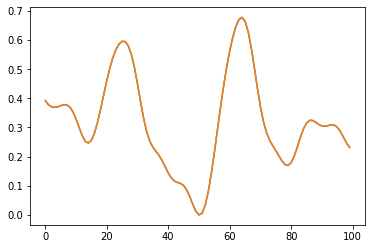

In [10]:
if debug:
    plt.figure()
    plt.plot(data['equal_time_rel']['latent'].squeeze(1).numpy())
    plt.plot(data['pink']['latent'].squeeze(1).numpy())

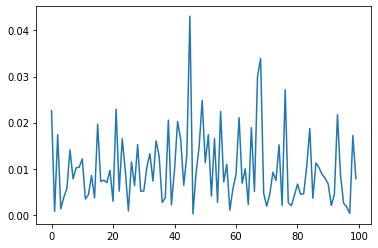

In [11]:
if debug:
    plt.figure()
    plt.plot(data['pink']['weights'][0].numpy())
#     plt.plot(data['equal_time_rel']['weights'][-77078].numpy())

In [12]:
data['pink']['targets'].sum()

tensor(158767.)

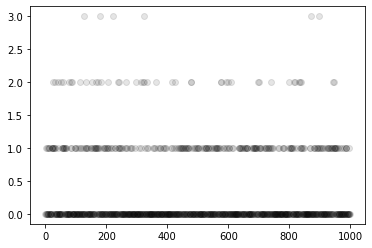

In [13]:
if debug:
    plt.figure()
    plt.plot(data['pink']['targets'][:1000].numpy(),'ko',alpha=0.1)
#     plt.plot(data['equal_time_rel']['weights'][-77078].numpy())

In [14]:
sigma2 = float(data['pink']['targets'].var())

amp_init = float(math.exp(0.1*params['snr_db']*math.log(10))*data['pink']['latent'].std())
model_pink_poisson = make_poisson_model(vec_len, inducing_points, nshots,
                        amplitude_init = amp_init,
                        #factor of 3 comes from different convention in inducing axis specification,
                        #               -3 to 3 vs -1 to 1
                       lengthscale_init = params['gibbs_kernel_params'][3]*3,
                       mean_bias_init = float(data['pink']['targets'].mean()),
                       dtype=torch.get_default_dtype())
model_pink_poisson.cuda()
hops_pink_poisson = model_pink_poisson.build_hyper_optimizer(default_lr=1e-2, inducing_lr=1e-8)
vops_pink_poisson = model_pink_poisson.build_variational_optimizer(default_lr=0.1)
logger_pink_poisson = logger_1D(model_pink_poisson)

In [15]:
tensor_data = TensorDataset(data['pink']['weights'].type(dtype),
                     data['pink']['targets'].type(dtype))
epochs = 150
for k in range(epochs):
    training_step(k, tensor_data, batch_size, model_pink_poisson,
                  hops_pink_poisson, vops_pink_poisson, 
                  logger_pink_poisson, cuda=use_cuda)

epoch 0: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.20673, layer.layer.layers.0.kernel.kernel._amplitude_storage: 0.309177, layer.layer.layers.0.prior_mean_func.bias: -1.1401, loss: 398062, lr: 0.000367388, 
epoch 10: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.202242, layer.layer.layers.0.kernel.kernel._amplitude_storage: 0.209226, layer.layer.layers.0.prior_mean_func.bias: -1.20167, loss: 357646, lr: 0.00472385, 


KeyboardInterrupt: 

In [16]:
model_pink_poisson.cpu()

Model(
  (layer): GPMM(
    (layer): LayerSequential(
      (layers): ModuleList(
        (0): Layer(
          (inducing): SharedInducingPoints()
          (kernel): CombinationSharedKernel(
            (kernel): RBFKernelScaled(lengthscale=tensor([[5.0000, 0.2024]]))
          )
          (output_transform): None
          (vp): SqrtVarParameterization(
            (storage): BatchedMVNSqrtVar(
              (packed_params): ModuleDict(
                (m): BatchedVector()
                (L): ConstrainedBatchedLowerTriangular()
              )
            )
          )
          (data_mean_func): None
          (prior_mean_func): BatchConstantMean(
            bias=Parameter containing:
            tensor([-1.2207], requires_grad=True)
          )
        )
      )
    )
  )
  (likelihood): MCOAIPoissonLikelihood()
)

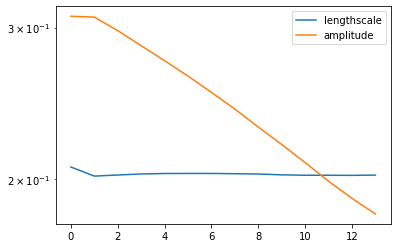

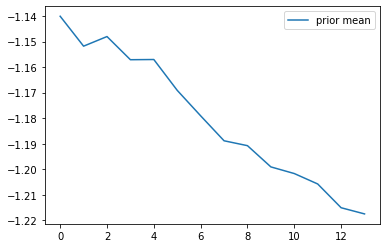

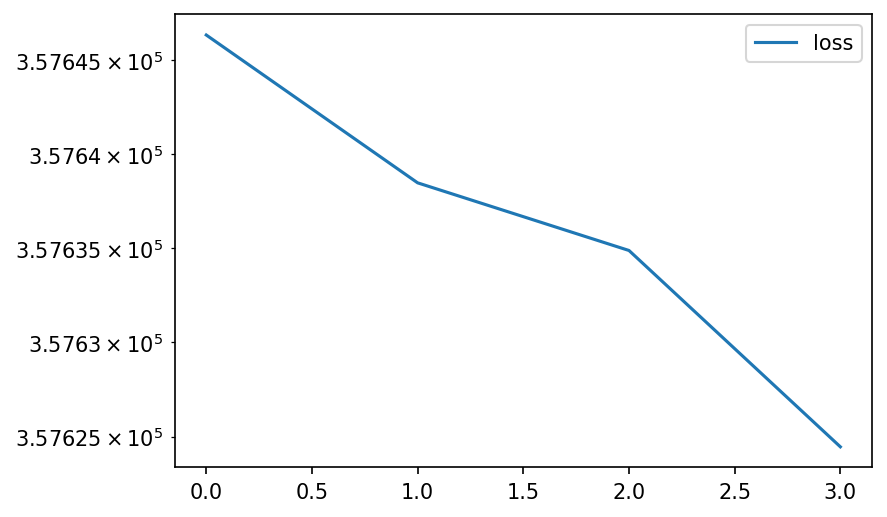

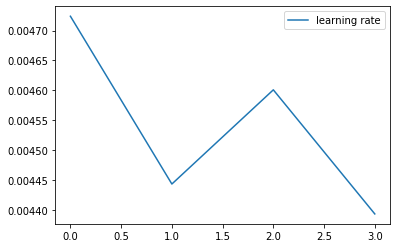

In [17]:
if debug:
    plot_training_curves(logger_pink_poisson)

{'mse': 0.9875348637737603,
 'l1': 7.634284308605556,
 'tlinf': 0.24005606959227846}

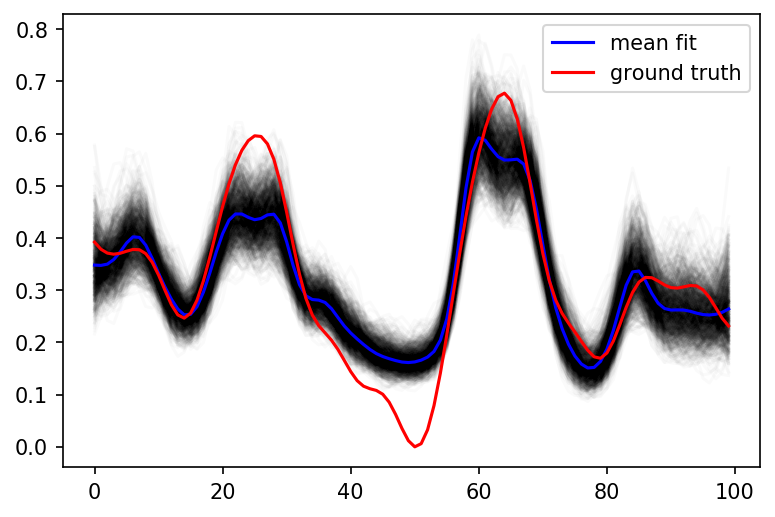

In [18]:
if debug:
    plot_fit(model_pink_poisson, data['pink'])

In [22]:
S_pink_poisson = summarize_to_xarray(params, data, model_pink_poisson, 'pink', coherence_metric)

In [19]:
model_pink_gaussian = make_gaussian_model(vec_len, inducing_points, nshots,
                      amplitude_init = float(math.exp(0.1*params['snr_db']*math.log(10))*data['pink']['latent'].std()),
                      lengthscale_init = params['gibbs_kernel_params'][3]*3,
                      mean_bias_init = float(data['pink']['targets'].mean()),
                      std_lik_init = math.sqrt(sigma2),
                      dtype=torch.get_default_dtype())
model_pink_gaussian.cuda()
hops_pink_gaussian = model_pink_gaussian.build_hyper_optimizer(default_lr=1e-2, inducing_lr=1e-8)
vops_pink_gaussian = model_pink_gaussian.build_variational_optimizer(default_lr=0.1)
logger_pink_gaussian = logger_1D(model_pink_gaussian)

In [20]:
tensor_data = TensorDataset(data['pink']['weights'].type(dtype),
                     data['pink']['targets'].type(dtype))
epochs = 50
for k in range(epochs):
    training_step(k, tensor_data, batch_size, model_pink_gaussian,
                  hops_pink_gaussian, vops_pink_gaussian, 
                  logger_pink_gaussian, cuda=use_cuda)

epoch 0: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.204731, layer.layer.layers.0.kernel.kernel._amplitude_storage: 0.0860999, layer.layer.layers.0.prior_mean_func.bias: -0.323251, loss: 432254, lr: 0.00264925, 
epoch 10: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.215102, layer.layer.layers.0.kernel.kernel._amplitude_storage: 0.0415063, layer.layer.layers.0.prior_mean_func.bias: 0.317991, loss: 422940, lr: 0.00621226, 
epoch 20: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.223471, layer.layer.layers.0.kernel.kernel._amplitude_storage: 0.0234706, layer.layer.layers.0.prior_mean_func.bias: 0.312828, loss: 422958, lr: 0.00676294, 
epoch 30: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.239787, layer.layer.layers.0.kernel.kernel._amplitude_storage: 0.0214599, layer.layer.layers.0.prior_mean_func.bias: 0.312583, loss: 422942, lr: 0.00706352, 
epoch 40: layer.layer.layers.0.kernel.kernel._lengthscale_storage: 0.259029, layer.layer.lay

KeyboardInterrupt: 

In [21]:
model_pink_gaussian.cpu()

Model(
  (layer): GPMM(
    (layer): LayerSequential(
      (layers): ModuleList(
        (0): Layer(
          (inducing): SharedInducingPoints()
          (kernel): CombinationSharedKernel(
            (kernel): RBFKernelScaled(lengthscale=tensor([[5.0000, 0.2802]]))
          )
          (output_transform): None
          (vp): SqrtVarParameterization(
            (storage): BatchedMVNSqrtVar(
              (packed_params): ModuleDict(
                (m): BatchedVector()
                (L): ConstrainedBatchedLowerTriangular()
              )
            )
          )
          (data_mean_func): None
          (prior_mean_func): BatchConstantMean(
            bias=Parameter containing:
            tensor([0.3212], requires_grad=True)
          )
        )
      )
    )
  )
  (likelihood): AnalyticOAIGaussianLikelihood()
)

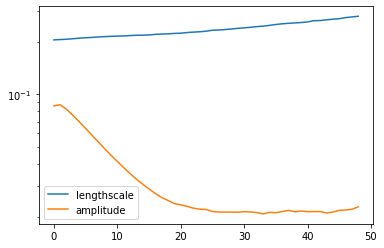

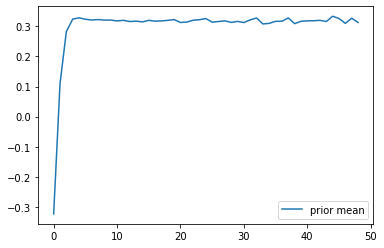

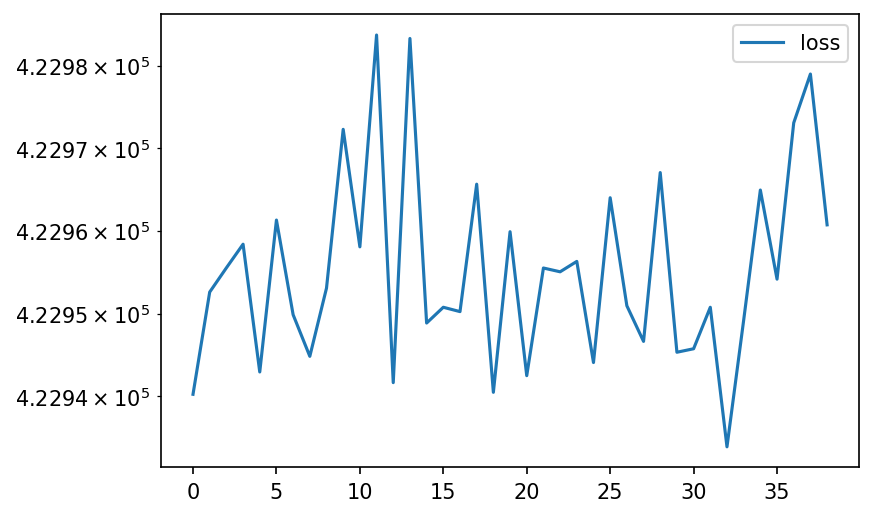

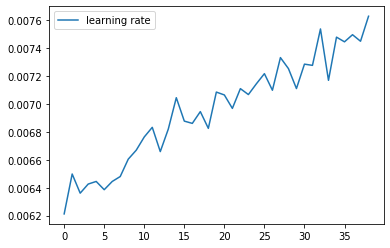

In [22]:
if debug:
    plot_training_curves(logger_pink_gaussian)

{'mse': 0.5806555753751931,
 'l1': 4.852913457465676,
 'tlinf': 0.15442260896798712}

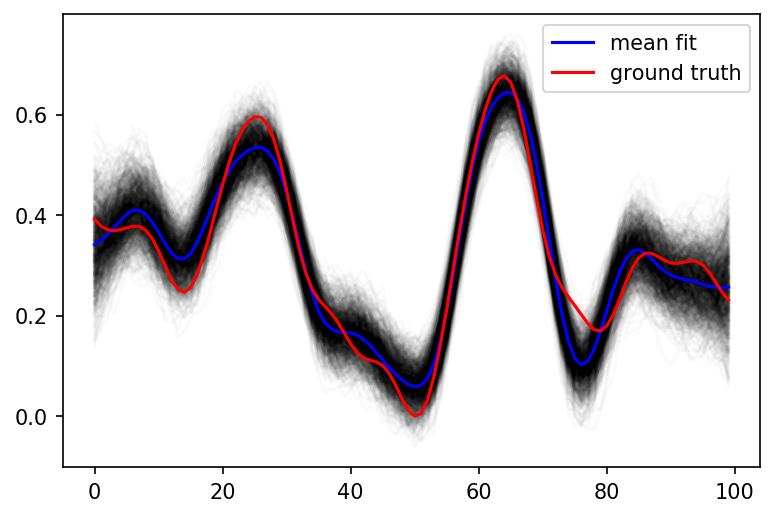

In [23]:
if debug:
    plot_fit(model_pink_gaussian, data['pink'])

In [28]:
S_pink_gaussian = summarize_to_xarray(params, data, model_pink_gaussian, 'pink', coherence_metric)

In [ ]:
sigma2 = float(data['equal_time_rel']['targets'].var())

amp_init = (math.sqrt(2)*float(math.exp(0.1*params['snr_db']
                                        *math.log(10))*data['equal_time_rel']['latent'].std()))
model_mono_poisson = make_poisson_model(vec_len, inducing_points, nshots,
                        amplitude_init = amp_init,
                        #factor of 3 comes from different convention in inducing axis specification,
                        #-3 to 3 vs -1 to 1
                       lengthscale_init = params['gibbs_kernel_params'][3]*3,
                       mean_bias_init = float(data['equal_time_rel']['targets'].mean()),
                       dtype=torch.get_default_dtype())
model_mono_poisson.cuda()
hops_mono_poisson = model_mono_poisson.build_hyper_optimizer(default_lr=1e-2, inducing_lr=1e-8)
vops_mono_poisson = model_mono_poisson.build_variational_optimizer(default_lr=0.1)
logger_mono_poisson = logger_1D(model_mono_poisson)

In [ ]:
tensor_data = TensorDataset(data['equal_time_rel']['weights'].type(dtype),
                     data['equal_time_rel']['targets'].type(dtype))
epochs = 150
for k in range(epochs):
    training_step(k, tensor_data, batch_size, model_mono_poisson,
                  hops_mono_poisson, vops_mono_poisson, 
                  logger_mono_poisson, cuda=use_cuda)

In [ ]:
model_mono_poisson.cpu()

In [ ]:
if debug:
    plot_training_curves(logger_mono_poisson)

In [ ]:
if debug:
    plot_fit(model_mono_poisson, data['equal_time_rel'])

In [ ]:
S_mono_poisson = summarize_to_xarray(params, data, model_mono_poisson, 'equal_time_rel', coherence_metric)

In [ ]:
amp_init = (math.sqrt(2)*float(math.exp(0.1*params['snr_db']
                                        *math.log(10))*data['equal_time_rel']['latent'].std()))
model_mono_gaussian = make_gaussian_model(vec_len, inducing_points, nshots,
                      amplitude_init = amp_init,
                      # factor of 3 comes from different convention in inducing axis specification,
                      #-3 to 3 vs -1 to 1
                      lengthscale_init = params['gibbs_kernel_params'][3]*3,
                      mean_bias_init = float(data['equal_time_rel']['targets'].mean()),
                      std_lik_init = math.sqrt(sigma2),
                      dtype=torch.get_default_dtype())
model_mono_gaussian.cuda()
hops_mono_gaussian = model_mono_gaussian.build_hyper_optimizer(default_lr=1e-2, inducing_lr=1e-8)
vops_mono_gaussian = model_mono_gaussian.build_variational_optimizer(default_lr=0.1)
logger_mono_gaussian = logger_1D(model_mono_gaussian)

In [ ]:
tensor_data = TensorDataset(data['equal_time_rel']['weights'].type(dtype),
                     data['equal_time_rel']['targets'].type(dtype))
epochs = 50
for k in range(epochs):
    training_step(k, tensor_data, batch_size, model_mono_gaussian,
                  hops_mono_gaussian, vops_mono_gaussian, 
                  logger_mono_gaussian, cuda=use_cuda)

In [ ]:
model_mono_gaussian.cpu()

In [ ]:
if debug:
    plot_training_curves(logger_mono_gaussian)

In [ ]:
if debug:
    plot_fit(model_mono_gaussian, data['equal_time_rel'])

In [ ]:
S_mono_gaussian = summarize_to_xarray(params, data, model_mono_gaussian, 'equal_time_rel', coherence_metric)

In [ ]:
Sp = xr.merge([S_pink_poisson, S_mono_poisson])
Sg = xr.merge([S_pink_gaussian, S_mono_gaussian])

In [ ]:
Sp.to_netcdf(fname_poisson, 'w')
Sg.to_netcdf(fname_gaussian, 'w')

In [ ]:
## Print number photons
pink_photons = data['pink']['targets'].sum()
mono_photons = data['equal_time_rel']['targets'].sum()
print(f'pink dataset photons: {pink_photons}')
print(f'mono dataset photons: {mono_photons}')